# Introduction to Optimal Transport with Python

#### *Rémi Flamary, Nicolas Courty*

## POT installation

+ Install with pip:
```bash
pip install pot
```
+ Install with conda
```bash
conda install -c conda-forge pot
```

## POT Python Optimal Transport Toolbox

#### Import the toolbox

In [3]:
import numpy as np # always need it
import scipy as sp # often use it
import pylab as pl # do the plots

import ot
import ot.plot# ot 

#### Getting help

Online  documentation : [http://pot.readthedocs.io](http://pot.readthedocs.io) 

Or inline help:


In [3]:
help(ot.datasets)

Help on module ot.datasets in ot:

NAME
    ot.datasets - Simple example datasets for OT

FUNCTIONS
    make_1D_gauss(n, m, s)
        return a 1D histogram for a gaussian distribution (n bins, mean m and std s)
        
        Parameters
        ----------
        n : int
            number of bins in the histogram
        m : float
            mean value of the gaussian distribution
        s : float
            standard deviaton of the gaussian distribution
        
        Returns
        -------
        h : ndarray (n,)
            1D histogram for a gaussian distribution
    
    make_2D_samples_gauss(n, m, sigma, random_state=None)
        Return n samples drawn from 2D gaussian N(m,sigma)
        
        Parameters
        ----------
        n : int
            number of samples to make
        m : ndarray, shape (2,)
            mean value of the gaussian distribution
        sigma : ndarray, shape (2, 2)
            covariance matrix of the gaussian distribution
        ran

## First OT Problem

We will solve the Bakery/Cafés problem of transporting croissants from a number of Bakeries to Cafés in a City (In this case Manhattan). We did a quick google map search in Manhattan for bakeries and Cafés:

![bak.png](https://remi.flamary.com/cours/otml/bak.png)

We extracted from this search their positions and generated fictional production and sale number (that both sum to the same value).

We have acess to the position of Bakeries ```bakery_pos``` and their respective production ```bakery_prod``` which describe the source distribution. The Cafés where the croissants are sold are defiend also by their position ```cafe_pos``` and ```cafe_prod```. For fun we also provide a map ```Imap``` that will illustrate the position of these shops in the city.


Now we load the data



In [5]:
data=np.load('data/manhattan.npz')

bakery_pos=data['bakery_pos']
bakery_prod=data['bakery_prod']
cafe_pos=data['cafe_pos']
cafe_prod=data['cafe_prod']
Imap=data['Imap']

print('Bakery production: {}'.format(bakery_prod))
print('Cafe sale: {}'.format(cafe_prod))
print('Total croissants : {}'.format(cafe_prod.sum()))

Bakery production: [31. 48. 82. 30. 40. 48. 89. 73.]
Cafe sale: [82. 88. 92. 88. 91.]
Total croissants : 441.0


In [6]:
lst = data.files
for item in lst:
    print(item)
    print(data[item])
    

cafe_pos
[[302.08410452 442.78633642]
 [345.1162221  368.52123027]
 [449.226184   201.94529124]
 [454.08464888 387.95508982]
 [627.60125204 408.7770822 ]]
cafe_prod
[82. 88. 92. 88. 91.]
bakery_prod
[31. 48. 82. 30. 40. 48. 89. 73.]
bakery_pos
[[184.86464733 201.8163543 ]
 [449.3486663  168.40784664]
 [245.41756746 288.12166576]
 [273.95400109 364.68282915]
 [494.58935376 336.8424061 ]
 [738.19305545 238.70491485]
 [736.10502372 375.12298779]
 [537.74200949 482.30861653]]
Imap
[[[179 189 198 255]
  [153 153 153 255]
  [153 153 153 255]
  ...
  [235 235 235 255]
  [235 235 235 255]
  [235 235 235 255]]

 [[212 236 255 255]
  [202 222 238 255]
  [174 182 189 255]
  ...
  [235 235 235 255]
  [235 235 235 255]
  [235 235 235 255]]

 [[183 224 255 255]
  [203 233 255 255]
  [212 236 255 255]
  ...
  [235 235 235 255]
  [235 235 235 255]
  [235 235 235 255]]

 ...

 [[230 230 230 255]
  [235 235 235 255]
  [235 235 235 255]
  ...
  [170 218 255 255]
  [170 218 255 255]
  [170 218 255 255]]



#### Plotting bakeries in the city

Next we plot the position of the bakeries and cafés on the map. The size of the circle is proportional to their production.


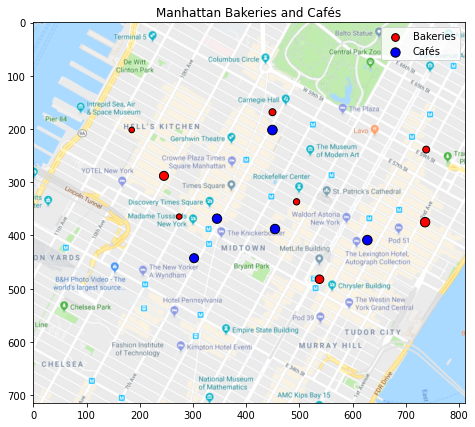

In [7]:

pl.figure(1,(8,7))
pl.clf()
pl.imshow(Imap,interpolation='bilinear') # plot the map
pl.scatter(bakery_pos[:,0],bakery_pos[:,1],s=bakery_prod,c='r', edgecolors='k',label='Bakeries')
pl.scatter(cafe_pos[:,0],cafe_pos[:,1],s=cafe_prod,c='b', edgecolors='k',label='Cafés')
pl.legend()
pl.title('Manhattan Bakeries and Cafés');


#### Cost matrix


We compute the cost matrix between the bakeries and the cafés, this will be the transport cost matrix. This can be done using the [ot.dist](http://pot.readthedocs.io/en/stable/all.html#ot.dist) that defaults to squared euclidean distance but can return other things such as cityblock (or manhattan distance). 



In [8]:
result = ot.dist(data["bakery_pos"],data["cafe_pos"],metric='sqeuclidean')
result


array([[ 71806.93342368,  53471.0828867 ,  69887.03869363,
        107127.03809694, 238848.44404326],
       [ 96970.40680838,  50909.76872922,   1124.77519163,
         48223.42151718,  89551.35372338],
       [ 27132.25677185,  16403.91170975,  48964.31969921,
         53508.66342873, 160622.09827457],
       [  6891.46056701,   5078.79502259,  57203.84434635,
         32988.64839201, 127010.6812586 ],
       [ 48282.38735754,  23345.76498866,  20255.04876894,
          4253.1375545 ,  22866.76271036],
       [231840.24371169, 171361.67266306,  84853.12272464,
        102993.20141004,  41155.08908898],
       [192952.48705117, 152915.82619273, 112289.98326498,
         79700.15466443,  12905.66653869],
       [ 57096.65880001,  50052.26323952,  86438.64553436,
         15901.14198628,  13481.57001385]])

#### Solving the OT problem with [ot.emd](http://pot.readthedocs.io/en/stable/all.html#ot.emd)

In [9]:
result1 = ot.emd(data['bakery_prod'],data['cafe_prod'],result,numItermax=100000,log=False)
result1

array([[ 0., 31.,  0.,  0.,  0.],
       [ 0.,  0., 48.,  0.,  0.],
       [52., 30.,  0.,  0.,  0.],
       [30.,  0.,  0.,  0.,  0.],
       [ 0., 27.,  0., 13.,  0.],
       [ 0.,  0., 44.,  2.,  2.],
       [ 0.,  0.,  0.,  0., 89.],
       [ 0.,  0.,  0., 73.,  0.]])

#### Transportation plan vizualization

A good vizualization of the OT matrix in the 2D plane is to denote the transportation of mass between a Bakery and a Café by a line. This can easily be done with a double ```for``` loop.

In order to make it more interpretable one can also use the ```alpha``` parameter of plot and set it to ```alpha=G[i,j]/G[i,j].max()```. 

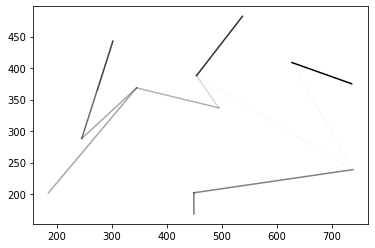

In [15]:
ot.plot.plot2D_samples_mat(data["bakery_pos"], data["cafe_pos"], result1, thr=1e-08)

#### OT loss and dual variables

The resulting wasserstein loss loss is of the form:

$W=\sum_{i,j}\gamma_{i,j}C_{i,j}$

where $\gamma$ is the optimal transport matrix.


In [10]:
wass_dist = ot.emd2(data['bakery_prod'],data['cafe_prod'],result,processes=4,numItermax=100000,log=False, return_matrix=False)
wass_dist

10838179.409852024

#### Regularized OT with SInkhorn

The Sinkhorn algorithm is very simple to code. You can implement it directly using the following pseudo-code:

![sinkhorn.png](http://remi.flamary.com/cours/otml/sink.png)

An alternative is to use the POT toolbox with [ot.sinkhorn](http://pot.readthedocs.io/en/stable/all.html#ot.sinkhorn)

Be carefull to numerical problems. A good pre-provcessing for Sinkhorn is to divide the cost matrix ```C```
 by its maximum value.

In [12]:
result = result / result.max()

sink = ot.sinkhorn(data['bakery_prod'],data['cafe_prod'],result,0.1,method='sinkhorn', numItermax=1000, stopThr=1e-09, verbose=False, log=False)
sink

array([[1.00416037e+01, 1.37328041e+01, 6.23706638e+00, 9.87724249e-01,
        8.01565086e-04],
       [1.18508628e+00, 5.17394370e+00, 3.75633747e+01, 3.93696614e+00,
        1.40629197e-01],
       [3.46328374e+01, 3.44443592e+01, 7.95769226e+00, 4.95384723e+00,
        1.12638970e-02],
       [1.57915377e+01, 1.08128957e+01, 1.10121003e+00, 2.28536698e+00,
        8.98961254e-03],
       [5.23923322e+00, 9.44592961e+00, 9.70851236e+00, 1.42855701e+01,
        1.32075473e+00],
       [7.63379114e-02, 6.09496306e-01, 2.05898321e+01, 7.25435993e+00,
        1.94699738e+01],
       [3.80308425e-01, 1.29025222e+00, 6.38378250e+00, 1.88121547e+01,
        6.21335022e+01],
       [1.46530554e+01, 1.24903191e+01, 2.45852969e+00, 3.54840107e+01,
        7.91408507e+00]])